In [3]:
#Basic Imports
import pandas as pd
import numpy as np

In [4]:
#sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing 
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [5]:
from skopt import BayesSearchCV
from sklearn.model_selection import GridSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import RandomForestClassifier
import pickle

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [8]:
#Natural Language Toolkit Imports
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
import nltk

In [9]:
import sys

sys.path.insert(0, '../Helper_Functions')
import functions as fn
import re

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/seanyboy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [10]:
sns.set_theme('talk')
plt.style.use('fivethirtyeight')

## Processing Text

This notebook will be used for various conventional model iterations. These models will be compared to deeper neural network models. I will select the best model and save them for later use.

In [11]:
df = pd.read_csv('../Data/product_processed.csv')

In [12]:
df['processed_text']=fn.Process_Tweet(df['tweet_text'],remove_HTML=True,remove_numerals=True,replace_moji_bake=True,remove_hashtags=True,contraction_fix=True,no_leading=True,lower=True,remove_mentions=True)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [13]:
df['processed_text'].head(5)

0     i have a  three g iphone. after  three  hrs t...
1     know about  ? awesome ipad/iphone app that yo...
2     can not wait for   two  also. they should sal...
3     i hope this year's festival is not as crashy ...
4     great stuff on fri : marissa mayer (google), ...
Name: processed_text, dtype: object

### Parts of Speech Tags

I will be attatching parts of speech tags for lemmitization processing.

In [14]:
#Grabbing Stopwords from NLTK
sw = stopwords.words('english')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/seanyboy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Changing Sentiment Target to Numeric

In [96]:
#Setting Target as numeric
df['Sentiment']=df['Sentiment'].replace({"Positive": 0, "Negative": 1, "Neutral": 3}).astype(np.uint8)
#combining neutral and positive sentiments
df['Sentiment']=df['Sentiment'].replace(3,0).copy()

In [16]:
# df=df[df['Sentiment']!=3]

In [97]:
y = df['Sentiment']

In [98]:
df['Sentiment'].value_counts(normalize=True)

0    0.925094
1    0.074906
Name: Sentiment, dtype: float64

Clearly still an imbalanced dataset, we are going to prioritize finding the minority class.

In [15]:
X = df['processed_text']
token_docs = [fn.doc_preparer(doc, sw) for doc in X]

In [20]:
#Create Training Data into a Dataframe with an index that corresponds to the target
X= pd.DataFrame(token_docs,columns=['processed_text'])
X.set_index(y.index,inplace=True)
X = X['processed_text']

In [21]:
X

0       three g iphone three hr tweet dead need upgrad...
1       know awesome ipad iphone app likely appreciate...
2                                      wait two also sale
3               hope year festival crashy year iphone app
4       great stuff fri marissa mayer google tim reill...
                              ...                        
7471                                 ipad everywhere link
7472    wave buzz rt interrupt regularly schedule geek...
7473    google zeiger physician never report potential...
7474    verizon iphone customer complain time fell bac...
7475                      rt google test check offer link
Name: processed_text, Length: 7476, dtype: object

## Train/Test/Split

I am splitting into a traditional train test split and then I will be splitting that into a training, validation set. I will not be looking at the test set until after final model selection.

In [22]:
len(X)

7476

In [23]:
X_train, X_rem, y_train, y_rem = train_test_split(X,
                                                    y,
                                                    random_state=20,
                                                    train_size=0.80,stratify=y)

In [24]:
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem,
                                          test_size=0.50, random_state=20,stratify=y_rem)

In [25]:
X_val

4570                         rt even begin apple win link
2694    glad get faulty iphone go well everyone batter...
1957    official present contest world best mobile app...
2795    save set open pop store despite two austin tex...
1754    google quash circle rumour rt launching produc...
                              ...                        
2213    win free ipad two webdoc com rt awesome tech r...
2798    school marketing expert thousand town demonstr...
4751    rt good cnn article important social web innov...
1595    alive love great talk jonathan dahl google mar...
6174               peep want ipad two link brilliant real
Name: processed_text, Length: 748, dtype: object

## Model Scoring Object

In [39]:
two_scorer = make_scorer(fbeta_score, beta=2)

In [40]:
cross_val_df = fn.cross_val_scores()

In [41]:
import importlib

## Modeling_Iterations

### Baseline Dummy

In [42]:
dummy_pipe = Pipeline(
    [
        ('tfidf',TfidfVectorizer(ngram_range=(1,2))),
        ('clf', DummyClassifier(strategy='stratified'))
    ]
)

In [43]:
dummy_pipe.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', DummyClassifier(strategy='stratified'))])

#### Dummy Scores

In [44]:
cross_val_df.cross_val_report(dummy_pipe,'Baseline Dummy',X_train,y_train)

[0.8620401337792643, 0.060199750312109855, 0.0728791012343349]

In [45]:
cross_val_df.history

,Name,mean_accuracy,std_accuracy,mean_precision,std_precision,mean_recall,std_recall,mean_f1,std_f1,notes
0,Baseline Dummy,0.86204,0.006739,0.072879,0.006144,0.0602,0.023794,0.072963,0.0093,


Due to the class imblance even a Dummy model achives an accuray score of 88%, it's imporant to look to precision and recall.

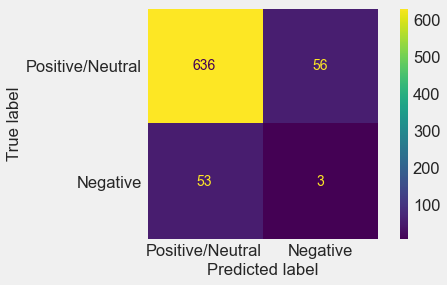

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       692
           1       0.04      0.04      0.04        56

    accuracy                           0.86       748
   macro avg       0.48      0.48      0.48       748
weighted avg       0.86      0.86      0.86       748



In [46]:
fn.reporting(dummy_pipe,X_val,y_val)

This is a clearly acceptable model. It sets a baseline.

### Logistic Regression

Given the class imbalance I am initiating a class_weight of balanced for the Logistic Regression baseline.

### Baseline - Bag of Words

In [47]:
Baseline_LG = Pipeline(
    [
        ('tfidf',TfidfVectorizer(ngram_range=(1,1),use_idf=False)),
        ('clf', LogisticRegression(class_weight='balanced',max_iter=1000))
    ]
)

In [48]:
Baseline_LG.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(use_idf=False)),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [49]:
cross_val_df.cross_val_report(Baseline_LG,'Baseline Logistic',X_train,y_train,'Balanced Weights/Ngrams 1,1,BoW')

[0.8297658862876254, 0.6157802746566793, 0.24581552577729368]

In [50]:
cross_val_df.history

,Name,mean_accuracy,std_accuracy,mean_precision,std_precision,mean_recall,std_recall,mean_f1,std_f1,notes
0,Baseline Dummy,0.862040,0.006739,0.072879,0.006144,0.06020,0.023794,0.072963,0.009300,
1,Baseline Logistic,0.829766,0.008388,0.245816,0.022980,0.61578,0.062758,0.351303,0.033441,"Balanced Weights/Ngrams 1,1,BoW"


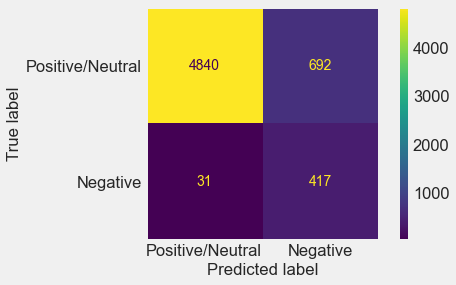

              precision    recall  f1-score   support

           0       0.99      0.87      0.93      5532
           1       0.38      0.93      0.54       448

    accuracy                           0.88      5980
   macro avg       0.68      0.90      0.73      5980
weighted avg       0.95      0.88      0.90      5980



In [51]:
fn.reporting(Baseline_LG,X_train,y_train)

The baseline Logistic is severely overfit, as there is an extreme difference in the training scores and the cross-validation scores.

In [52]:
validation_scores = fn.model_scores()

In [53]:
validation_scores.report(Baseline_LG,'baseline_logistic',X_val,y_val,'n_grams 1,1,BoW')

[0.8275401069518716, 0.6428571428571429, 0.2482758620689655]

In [54]:
validation_scores.history

,Name,accuracy,precision,recall,f1,notes
0,baseline_logistic,0.82754,0.248276,0.642857,0.358209,"n_grams 1,1,BoW"


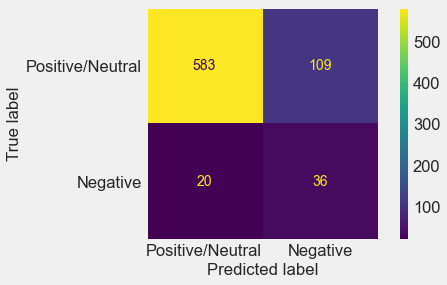

              precision    recall  f1-score   support

           0       0.97      0.84      0.90       692
           1       0.25      0.64      0.36        56

    accuracy                           0.83       748
   macro avg       0.61      0.74      0.63       748
weighted avg       0.91      0.83      0.86       748



In [55]:
fn.reporting(Baseline_LG,X_val,y_val)

### Bag of Words - (1,2 Ngrams)

In [56]:
LG_1_2_grams = Pipeline(
    [
        ('tfidf',TfidfVectorizer(ngram_range=(1,2),use_idf=False)),
        ('clf', LogisticRegression(class_weight='balanced',max_iter=1000))
    ]
)

In [57]:
LG_1_2_grams.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2), use_idf=False)),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [58]:
cross_val_df.cross_val_report(LG_1_2_grams,'Logistic_BOW',X_train,y_train,'N_Grams_1,2')

[0.8628762541806021, 0.5533083645443195, 0.28522944490951585]

In [59]:
validation_scores.report(LG_1_2_grams,'Logistic_BOW',X_val,y_val,'N_gram_1,2')

[0.8743315508021391, 0.6428571428571429, 0.32727272727272727]

### TFIDF (1,1 Ngrams)

In [60]:
LG_1_1_tfidf = Pipeline(
    [
        ('tfidf',TfidfVectorizer(ngram_range=(1,1),use_idf=True)),
        ('clf', LogisticRegression(class_weight='balanced',max_iter=1000))
    ]
)

In [61]:
LG_1_1_tfidf.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [62]:
cross_val_df.cross_val_report(LG_1_1_tfidf,'Logistic_TFIDF',X_train,y_train,'N_grams1,1')

[0.867056856187291, 0.5845443196004994, 0.3001155354209293]

In [63]:
validation_scores.report(LG_1_1_tfidf,'Logistic_TFIDF',X_val,y_val,'N_gram_1,1')

[0.8716577540106952, 0.625, 0.3181818181818182]

In [64]:
cross_val_df.history

,Name,mean_accuracy,std_accuracy,mean_precision,std_precision,mean_recall,std_recall,mean_f1,std_f1,notes
0,Baseline Dummy,0.862040,0.006739,0.072879,0.006144,0.060200,0.023794,0.072963,0.009300,
1,Logistic_BOW,0.862876,0.006099,0.285229,0.022435,0.553308,0.062936,0.376122,0.032752,"N_Grams_1,2"
3,Logistic_TFIDF,0.867057,0.004164,0.300116,0.021531,0.584544,0.057838,0.396524,0.032114,"N_grams1,1"
2,Baseline Logistic,0.829766,0.008388,0.245816,0.022980,0.615780,0.062758,0.351303,0.033441,"Balanced Weights/Ngrams 1,1,BoW"


### TFIDF (1,2 Ngrams)

In [65]:
LG_1_2_tfidf = Pipeline(
    [
        ('tfidf',TfidfVectorizer(ngram_range=(1,2),use_idf=True)),
        ('clf', LogisticRegression(class_weight='balanced',max_iter=1000))
    ]
)

In [66]:
LG_1_2_tfidf.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [67]:
cross_val_df.cross_val_report(LG_1_2_tfidf,'Logistic_TFIDF',X_train,y_train,'N_grams1,2')


[0.8986622073578596, 0.43745318352059925, 0.35762510650367724]

In [68]:
validation_scores.report(LG_1_2_tfidf,'Logistic_TFIDF',X_val,y_val,'N_gram_1,2')


[0.9010695187165776, 0.5714285714285714, 0.3902439024390244]

In [69]:
cross_val_df.history

,Name,mean_accuracy,std_accuracy,mean_precision,std_precision,mean_recall,std_recall,mean_f1,std_f1,notes
0,Baseline Dummy,0.862040,0.006739,0.072879,0.006144,0.060200,0.023794,0.072963,0.009300,
4,Logistic_TFIDF,0.898662,0.006983,0.357625,0.031299,0.437453,0.025999,0.393250,0.028001,"N_grams1,2"
1,Logistic_BOW,0.862876,0.006099,0.285229,0.022435,0.553308,0.062936,0.376122,0.032752,"N_Grams_1,2"
2,Logistic_TFIDF,0.867057,0.004164,0.300116,0.021531,0.584544,0.057838,0.396524,0.032114,"N_grams1,1"
3,Baseline Logistic,0.829766,0.008388,0.245816,0.022980,0.615780,0.062758,0.351303,0.033441,"Balanced Weights/Ngrams 1,1,BoW"


In [55]:
LG_2_2_tfidf = Pipeline(
    [
        ('tfidf',TfidfVectorizer(ngram_range=(2,2),use_idf=True)),
        ('clf', LogisticRegression(class_weight='balanced',max_iter=1000))
    ]
)

In [56]:
LG_2_2_tfidf.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(2, 2))),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [57]:
cross_val_df.cross_val_report(LG_2_2_tfidf,'Logistic_TFIDF',X_train,y_train,'N_grams2,2')


[0.9135451505016723, 0.2990012484394507, 0.39543628086127136]

### Tuned Logistic Regression

In [58]:
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV

In [59]:
param_space = {'clf__class_weight': ['none','balanced'],'clf__C':[.01,.1,1,5,10,100],'tfidf__use_idf':[True,False],
              'tfidf__smooth_idf':[True,False],'tfidf__sublinear_tf':[True,False],
                                  'tfidf__ngram_range': [(1, 1), (1,2),(1,3)]}


In [61]:
%%time

LG_GS = GridSearchCV(estimator=Baseline_LG,param_grid=param_space,cv=5,scoring=two_scorer,refit=True,n_jobs=-1)
LG_GS.fit(X_train,y_train)

CPU times: user 9.72 s, sys: 916 ms, total: 10.6 s
Wall time: 7min 20s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(use_idf=False)),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.01, 0.1, 1, 5, 10, 100],
                         'clf__class_weight': ['none', 'balanced'],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tfidf__smooth_idf': [True, False],
                         'tfidf__sublinear_tf': [True, False],
                         'tfidf__use_idf': [True, False]},
             scoring=make_scorer(fbeta_score, beta=2))

In [62]:
LG_GS.best_params_

{'clf__C': 1,
 'clf__class_weight': 'balanced',
 'tfidf__ngram_range': (1, 1),
 'tfidf__smooth_idf': True,
 'tfidf__sublinear_tf': False,
 'tfidf__use_idf': True}

In [63]:
cross_val_df.cross_val_report(LG_GS.best_estimator_,'Tuned Logistic Regression',X_train,y_train)


[0.867056856187291, 0.5845443196004994, 0.3001155354209293]

In [64]:
cross_val_df.history.sort_values('mean_recall')

,Name,mean_accuracy,std_accuracy,mean_precision,std_precision,mean_recall,std_recall,mean_f1,std_f1,notes
0,Baseline Dummy,0.863880,0.009635,0.081676,0.036418,0.069139,0.026880,0.066957,0.012847,
1,Logistic_TFIDF,0.913545,0.009138,0.395436,0.086763,0.299001,0.072966,0.339969,0.078817,"N_grams2,2"
2,Logistic_TFIDF,0.898662,0.006983,0.357625,0.031299,0.437453,0.025999,0.393250,0.028001,"N_grams1,2"
3,Logistic_BOW,0.862876,0.006099,0.285229,0.022435,0.553308,0.062936,0.376122,0.032752,"N_Grams_1,2"
4,Logistic_TFIDF,0.867057,0.004164,0.300116,0.021531,0.584544,0.057838,0.396524,0.032114,"N_grams1,1"
6,Tuned Logistic Regression,0.867057,0.004164,0.300116,0.021531,0.584544,0.057838,0.396524,0.032114,
5,Baseline Logistic,0.829766,0.008388,0.245816,0.022980,0.615780,0.062758,0.351303,0.033441,"Balanced Weights/Ngrams 1,1,BoW"


In [65]:
validation_scores.report(Baseline_LG,'Tuned Logistic',X_val,y_val)


[0.8275401069518716, 0.6428571428571429, 0.2482758620689655]

In [66]:
validation_scores.history

,Name,accuracy,precision,recall,f1,notes
0,Logistic_TFIDF,0.901070,0.390244,0.571429,0.463768,"N_gram_1,2"
1,Logistic_TFIDF,0.871658,0.318182,0.625000,0.421687,"N_gram_1,1"
2,baseline_logistic,0.827540,0.248276,0.642857,0.358209,"n_grams 1,1,BoW"
3,Logistic_BOW,0.874332,0.327273,0.642857,0.433735,"N_gram_1,2"
4,Tuned Logistic,0.827540,0.248276,0.642857,0.358209,


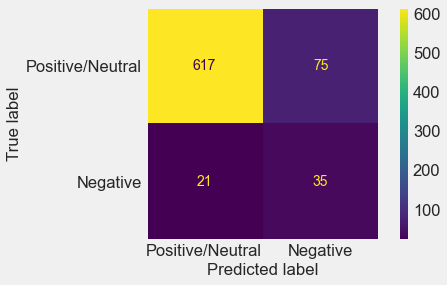

              precision    recall  f1-score   support

           0       0.97      0.89      0.93       692
           1       0.32      0.62      0.42        56

    accuracy                           0.87       748
   macro avg       0.64      0.76      0.67       748
weighted avg       0.92      0.87      0.89       748



In [67]:
fn.reporting(LG_GS.best_estimator_,X_val,y_val)


### Baseline Support Vector Machine

In [68]:
from sklearn import svm

In [69]:
Baseline_svm = Pipeline(
    [
        ('tfidf',TfidfVectorizer(ngram_range=(1,1),use_idf=False)),
        ('svm', svm.SVC())
    ]
)


In [70]:
Baseline_svm.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(use_idf=False)), ('svm', SVC())])

In [71]:
cross_val_df.cross_val_report(Baseline_svm,'Baseline_svm',X_train,y_train)


[0.9280936454849499, 0.05585518102372035, 0.8222222222222222]

### Support Vectmor Machine Ngram 1,2

In [72]:
SVM_1_2 = Pipeline(
    [
        ('tfidf',TfidfVectorizer(ngram_range=(1,2),use_idf=False)),
        ('svm', svm.SVC())
    ]
)
SVM_1_2.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2), use_idf=False)),
                ('svm', SVC())])

In [73]:
cross_val_df.cross_val_report(SVM_1_2,'SVM_BOW',X_train,y_train,'ngram 1,2')

[0.9280936454849499, 0.06029962546816479, 0.7966666666666666]

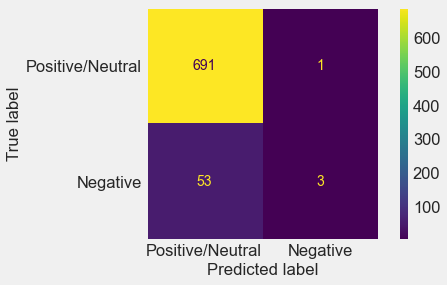

              precision    recall  f1-score   support

           0       0.93      1.00      0.96       692
           1       0.75      0.05      0.10        56

    accuracy                           0.93       748
   macro avg       0.84      0.53      0.53       748
weighted avg       0.92      0.93      0.90       748



In [74]:
fn.reporting(SVM_1_2,X_val,y_val)

### Support Vector TFIDF

In [75]:
SVM_tfidf_1_1 = Pipeline(
    [
        ('tfidf',TfidfVectorizer(ngram_range=(1,1),use_idf=True)),
        ('svm', svm.SVC())
    ]
)
SVM_tfidf_1_1.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('svm', SVC())])

In [76]:
cross_val_df.cross_val_report(SVM_tfidf_1_1,'SVM_TFIDF',X_train,y_train,'ngram_1,1')


[0.9285953177257525, 0.07143570536828964, 0.7904761904761906]

In [77]:
SVM_tfidf_1_2 = Pipeline(
    [
        ('tfidf',TfidfVectorizer(ngram_range=(1,2),use_idf=True)),
        ('svm', svm.SVC())
    ]
)
SVM_tfidf_1_2.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))), ('svm', SVC())])

In [78]:
cross_val_df.cross_val_report(SVM_tfidf_1_2,'SVM_TFIDF',X_train,y_train,'ngram_1,2')


[0.9285953177257525, 0.06699126092384519, 0.8068831168831169]

In [79]:
param_grid = {'svm__C': [0.1,1, 10,15,20], 'svm__gamma': [1,0.1,0.01,0.001],'svm__kernel': ['rbf', 'poly', 'sigmoid'],
             'tfidf__use_idf':[True, False],'tfidf__ngram_range':[(1,1),(1,2)],'svm__class_weight':[None,'balanced']}

In [80]:
tuned_svm = GridSearchCV(estimator=Baseline_svm,param_grid=param_grid,cv=5,scoring=two_scorer,refit=True,n_jobs=-1)

In [81]:
SVM_tfidf_3 = Pipeline(
    [
        ('tfidf',TfidfVectorizer(ngram_range=(1,2),use_idf=True)),
        ('svm', svm.SVC(C=20,gamma=1,kernel='sigmoid',class_weight='balanced'))
    ]
)
SVM_tfidf_3.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('svm',
                 SVC(C=20, class_weight='balanced', gamma=1,
                     kernel='sigmoid'))])

In [82]:
tuned_svm.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(use_idf=False)),
                                       ('svm', SVC())]),
             n_jobs=-1,
             param_grid={'svm__C': [0.1, 1, 10, 15, 20],
                         'svm__class_weight': [None, 'balanced'],
                         'svm__gamma': [1, 0.1, 0.01, 0.001],
                         'svm__kernel': ['rbf', 'poly', 'sigmoid'],
                         'tfidf__ngram_range': [(1, 1), (1, 2)],
                         'tfidf__use_idf': [True, False]},
             scoring=make_scorer(fbeta_score, beta=2))

In [83]:
cross_val_df.cross_val_report(tuned_svm.best_estimator_,'Tuned_SVM',X_train,y_train)


[0.8560200668896322, 0.6114107365792759, 0.28469932844932844]

### Baseline Compliment Bayes

In [84]:
Baseline_CB = Pipeline(
    [
        ('tfidf',TfidfVectorizer(ngram_range=(1,2))),
        ('cnb', ComplementNB())
    ]
)


In [85]:
Baseline_CB.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('cnb', ComplementNB())])

In [86]:
cross_val_df.cross_val_report(Baseline_CB,'Baseline Bayes',X_train,y_train)

[0.9292642140468228, 0.14499375780274656, 0.6144991100940758]

In [87]:
cross_val_df.history

,Name,mean_accuracy,std_accuracy,mean_precision,std_precision,mean_recall,std_recall,mean_f1,std_f1,notes
0,Baseline_svm,0.928094,0.001399,0.822222,0.093953,0.055855,0.023476,0.102999,0.042225,
1,SVM_BOW,0.928094,0.000916,0.796667,0.112744,0.060300,0.020735,0.110521,0.036022,"ngram 1,2"
2,SVM_TFIDF,0.928595,0.000853,0.806883,0.110288,0.066991,0.018701,0.122359,0.031673,"ngram_1,2"
3,Baseline Dummy,0.863880,0.009635,0.081676,0.036418,0.069139,0.026880,0.066957,0.012847,
4,SVM_TFIDF,0.928595,0.000853,0.790476,0.122706,0.071436,0.026914,0.128624,0.043989,"ngram_1,1"
12,Baseline Bayes,0.929264,0.002727,0.614499,0.087212,0.144994,0.028733,0.234251,0.043402,
5,Logistic_TFIDF,0.913545,0.009138,0.395436,0.086763,0.299001,0.072966,0.339969,0.078817,"N_grams2,2"
6,Logistic_TFIDF,0.898662,0.006983,0.357625,0.031299,0.437453,0.025999,0.393250,0.028001,"N_grams1,2"
7,Logistic_BOW,0.862876,0.006099,0.285229,0.022435,0.553308,0.062936,0.376122,0.032752,"N_Grams_1,2"
8,Logistic_TFIDF,0.867057,0.004164,0.300116,0.021531,0.584544,0.057838,0.396524,0.032114,"N_grams1,1"


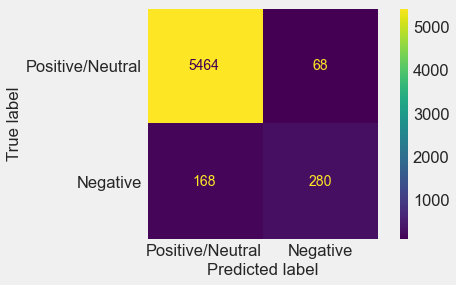

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      5532
           1       0.80      0.62      0.70       448

    accuracy                           0.96      5980
   macro avg       0.89      0.81      0.84      5980
weighted avg       0.96      0.96      0.96      5980



In [88]:
fn.reporting(Baseline_CB,X_train,y_train)

In [89]:
validation_scores.report(Baseline_CB,'Baseline CB',X_val,y_val)

[0.9264705882352942, 0.125, 0.5384615384615384]

In [90]:
validation_scores.history

,Name,accuracy,precision,recall,f1,notes
5,Baseline CB,0.926471,0.538462,0.125000,0.202899,
0,Logistic_TFIDF,0.901070,0.390244,0.571429,0.463768,"N_gram_1,2"
1,Logistic_TFIDF,0.871658,0.318182,0.625000,0.421687,"N_gram_1,1"
2,baseline_logistic,0.827540,0.248276,0.642857,0.358209,"n_grams 1,1,BoW"
3,Logistic_BOW,0.874332,0.327273,0.642857,0.433735,"N_gram_1,2"
4,Tuned Logistic,0.827540,0.248276,0.642857,0.358209,


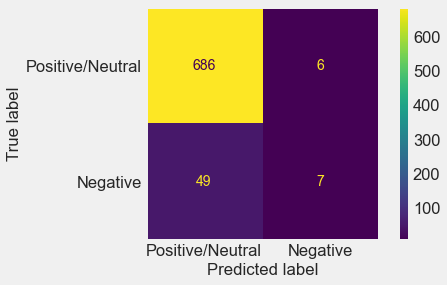

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       692
           1       0.54      0.12      0.20        56

    accuracy                           0.93       748
   macro avg       0.74      0.56      0.58       748
weighted avg       0.90      0.93      0.90       748



In [91]:
fn.reporting(Baseline_CB,X_val,y_val)

### Tuned Compliment Bayes

In [92]:
param_grid = {'cnb__alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
               'tfidf__ngram_range': [(1, 1), (1,2),(1,3)],
              'cnb__class_prior': [None, [.07, .93]],
                'cnb__fit_prior': [True, False],'tfidf__use_idf':[True,False],
              'tfidf__smooth_idf':[True,False],'tfidf__sublinear_tf':[True,False]
                                      }

In [93]:
import multiprocessing

multiprocessing.cpu_count()

4

In [94]:
%%time

CB_GS = GridSearchCV(estimator=Baseline_CB,param_grid=param_grid,cv=5,scoring=two_scorer,refit=True,n_jobs=-1)
CB_GS.fit(X_train,y_train)

CPU times: user 14.2 s, sys: 1.26 s, total: 15.5 s
Wall time: 4min 40s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(ngram_range=(1, 2))),
                                       ('cnb', ComplementNB())]),
             n_jobs=-1,
             param_grid={'cnb__alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
                         'cnb__class_prior': [None, [0.07, 0.93]],
                         'cnb__fit_prior': [True, False],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tfidf__smooth_idf': [True, False],
                         'tfidf__sublinear_tf': [True, False],
                         'tfidf__use_idf': [True, False]},
             scoring=make_scorer(fbeta_score, beta=2))

In [95]:
CB_GS.best_params_

{'cnb__alpha': 0.1,
 'cnb__class_prior': None,
 'cnb__fit_prior': True,
 'tfidf__ngram_range': (1, 1),
 'tfidf__smooth_idf': False,
 'tfidf__sublinear_tf': True,
 'tfidf__use_idf': True}

In [96]:
validation_scores.report(CB_GS.best_estimator_,'Tune Comp Bayes',X_val,y_val)

[0.8409090909090909, 0.6071428571428571, 0.2595419847328244]

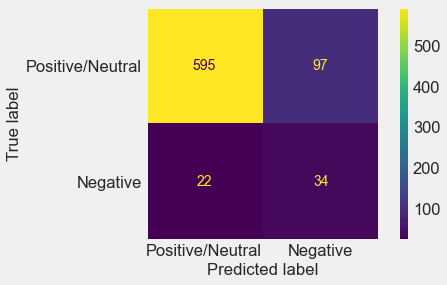

              precision    recall  f1-score   support

           0       0.96      0.86      0.91       692
           1       0.26      0.61      0.36        56

    accuracy                           0.84       748
   macro avg       0.61      0.73      0.64       748
weighted avg       0.91      0.84      0.87       748



In [97]:
fn.reporting(CB_GS,X_val,y_val)

In [98]:
df['Sentiment'].value_counts(normalize=True)

0    0.925094
1    0.074906
Name: Sentiment, dtype: float64

In [99]:
validation_scores.history

,Name,accuracy,precision,recall,f1,notes
0,Baseline CB,0.926471,0.538462,0.125000,0.202899,
1,Logistic_TFIDF,0.901070,0.390244,0.571429,0.463768,"N_gram_1,2"
6,Tune Comp Bayes,0.840909,0.259542,0.607143,0.363636,
2,Logistic_TFIDF,0.871658,0.318182,0.625000,0.421687,"N_gram_1,1"
3,baseline_logistic,0.827540,0.248276,0.642857,0.358209,"n_grams 1,1,BoW"
4,Logistic_BOW,0.874332,0.327273,0.642857,0.433735,"N_gram_1,2"
5,Tuned Logistic,0.827540,0.248276,0.642857,0.358209,


### Baseline Random Forrest Classifier

In [100]:
Baseline_RF = Pipeline(
    [
        ('tfidf',TfidfVectorizer(ngram_range=(1,2))),
        ('RF', RandomForestClassifier())
    ]
)

In [101]:
%%time

Baseline_RF.fit(X_train,y_train)

CPU times: user 3.62 s, sys: 41.9 ms, total: 3.67 s
Wall time: 3.78 s


Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('RF', RandomForestClassifier())])

In [103]:
cross_val_df.cross_val_report(Baseline_RF,'Baseline Random Forrest',X_train,y_train)

[0.9311036789297658, 0.16729088639201, 0.665597606055272]

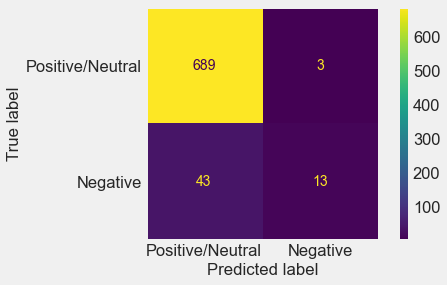

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       692
           1       0.81      0.23      0.36        56

    accuracy                           0.94       748
   macro avg       0.88      0.61      0.66       748
weighted avg       0.93      0.94      0.92       748



In [104]:
fn.reporting(Baseline_RF,X_val,y_val)

### Tuned Random Forrest

In [105]:
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV

In [106]:
random_grid = {'RF__class_weight': ["balanced", "balanced_subsample"], 'tfidf__ngram_range': [(1, 1), (1,2),(1,3)],
                                    'RF__max_depth': [5, 10, 15, 20, 30, None],
                                    'RF__n_estimators': [50,100,150],'tfidf__use_idf':[True,False],
              'tfidf__smooth_idf':[True,False],'tfidf__sublinear_tf':[True,False]
                                  }


In [107]:
param_space = {
        'RF__class_weight': Categorical(["balanced", "balanced_subsample"]),
        "tfidf__ngram_range": Categorical([(1, 1), (1,2),(1,3)]),
        "RF__max_depth": Integer(4, 30),
        
        'tfidf__smooth_df':Categorical([True,False]),
        'tfidf__sublinear_tf':Categorical([True,False]),
        "RF__n_estimators": Integer(50, 300)
        }

In [ ]:
%%time

RF_GS = GridSearchCV(estimator=Baseline_RF,param_grid=random_grid,cv=5,scoring=two_scorer,refit=True,n_jobs=-1)
RF_GS.fit(X_train,y_train)

In [ ]:
RF_GS.best_params_

In [ ]:
#Saving the grid search best model into a pickle
filename = 'Random_Forrest_Grid_Search.sav'
pickle.dump(RF_GS.best_estimator_, open(filename, 'wb'))

In [113]:
RF_GS = pickle.load(open('Random_Forrest_Grid_Search.sav', 'rb'))

In [116]:
cross_val_df.cross_val_report(RF_GS,'Grid RF',X_train,y_train,'Grid Search Random Forrest')

[0.7224080267558529, 0.6427465667915107, 0.156377444623574]

In [117]:
validation_scores.report(RF_GS,'Grid Search Random Forrest',X_val,y_val)

[0.6550802139037433, 0.7142857142857143, 0.14184397163120568]

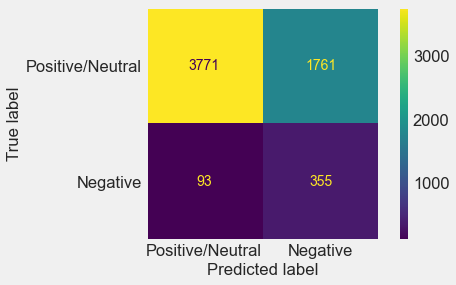

              precision    recall  f1-score   support

           0       0.98      0.68      0.80      5532
           1       0.17      0.79      0.28       448

    accuracy                           0.69      5980
   macro avg       0.57      0.74      0.54      5980
weighted avg       0.92      0.69      0.76      5980



In [119]:
fn.reporting(RF_GS,X_train,y_train)

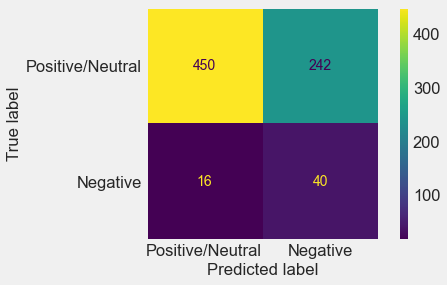

              precision    recall  f1-score   support

           0       0.97      0.65      0.78       692
           1       0.14      0.71      0.24        56

    accuracy                           0.66       748
   macro avg       0.55      0.68      0.51       748
weighted avg       0.90      0.66      0.74       748



In [120]:
fn.reporting(RF_GS,X_val,y_val)

My attempt at tuning the Random Forrest did not yield very good results. The model is now guessing many more negatives, and still missing roughly half of the actual negative cases. Hopefully adding more negative cases will help the model improve.

In [121]:
validation_scores.history

,Name,accuracy,precision,recall,f1,notes
0,Baseline CB,0.926471,0.538462,0.125000,0.202899,
1,Logistic_TFIDF,0.901070,0.390244,0.571429,0.463768,"N_gram_1,2"
2,Tune Comp Bayes,0.840909,0.259542,0.607143,0.363636,
3,Logistic_TFIDF,0.871658,0.318182,0.625000,0.421687,"N_gram_1,1"
4,baseline_logistic,0.827540,0.248276,0.642857,0.358209,"n_grams 1,1,BoW"
5,Logistic_BOW,0.874332,0.327273,0.642857,0.433735,"N_gram_1,2"
6,Tuned Logistic,0.827540,0.248276,0.642857,0.358209,
7,Grid Search Random Forrest,0.655080,0.141844,0.714286,0.236686,


## Additional Negative Examples

Given the scores I'm dealing with I will be using the additional negative tweets to supplement this model.

### Text Processing

In [17]:
new_df = pd.read_csv('additional_negs')


In [18]:
new_df['processed_text'] = fn.Process_Tweet(new_df['tweet_text'],remove_HTML=True,replace_moji_bake=True,strip_links=True,no_leading=True,contraction_fix=True,remove_numerals=True,remove_hashtags=False,remove_mentions=True)

In [19]:
X = new_df['processed_text']
token_docs = [fn.doc_preparer(doc, sw) for doc in X]


In [73]:
new_df['Sentiment']=new_df['Sentiment'].replace({"Positive": 0, "Negative": 1, "Neutral": 3}).astype(np.uint8)
new_df['Sentiment']=new_df['Sentiment'].replace(3,0).copy()


In [74]:
y = new_df['Sentiment']


In [75]:
new_df['Sentiment'].value_counts(normalize=True)


0    0.823831
1    0.176169
Name: Sentiment, dtype: float64

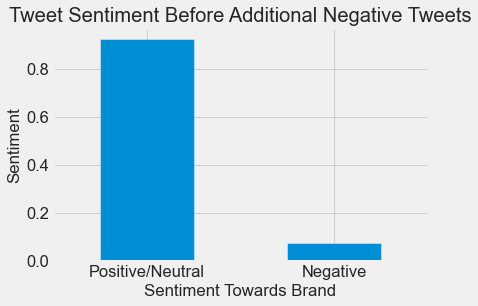

In [99]:
fig, ax = plt.subplots()

labels=['Positive/Neutral','Negative']
plt.style.use('fivethirtyeight')
df['Sentiment'].value_counts(normalize=True).plot.bar()
plt.title('Tweet Sentiment Before Additional Negative Tweets')
plt.ylabel('Sentiment')
plt.xlabel('Sentiment Towards Brand')
plt.xticks(rotation=0)
ax.set_xticklabels(labels=labels)
plt.show()

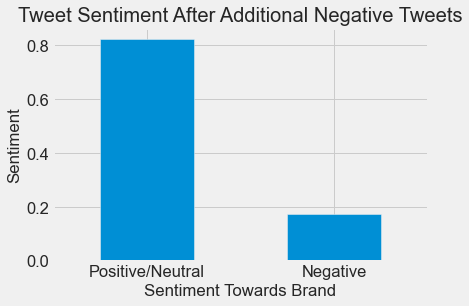

In [79]:
fig, ax = plt.subplots()

labels=['Positive/Neutral','Negative']


plt.style.use('fivethirtyeight')
new_df['Sentiment'].value_counts(normalize=True).plot.bar()
plt.title('Tweet Sentiment After Additional Negative Tweets')
plt.ylabel('Sentiment')
plt.xlabel('Sentiment Towards Brand')
plt.xticks(rotation=0)
ax.set_xticklabels(labels=labels)
plt.show()

In [130]:
X= pd.DataFrame(token_docs,columns=['processed_text'])
X.set_index(y.index,inplace=True)
X = X['processed_text']


### Train/Test/Split

In [70]:
X = new_df['processed_text']
y = new_df['Sentiment']


In [71]:
corpus = ''.join(X_train)
corpus = [corpus]

In [72]:
tokenizer = lambda docs: [vectorizer.build_tokenizer()(doc) for doc in X_train]

In [74]:
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(corpus)

<1x8832 sparse matrix of type '<class 'numpy.float64'>'
	with 8832 stored elements in Compressed Sparse Row format>

In [75]:
len(X)


10155

In [76]:
X_train, X_rem, y_train, y_rem = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    train_size=0.80,stratify=y)

In [77]:
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem,
                                          test_size=0.50, random_state=42,stratify=y_rem)


In [78]:
len(X_test)


1016

In [79]:
X_val

1402    Startups: Free Premium Service on your  one st...
4801    Umm. Hello!! What about Android?! RT  Awesome ...
2356     Congrats on your iPhone app being featured at...
1484    like that is bad RT  Sitting at a bar listenin...
2427    UBER BRAND SMART: Going To move a ton of iPad ...
                              ...                        
9176        lol iPhone,weak. Get on that Lumia level bruh
1499    Hmm...cannot get Twitter searches to update in...
3291    Abba has gotten dissed at  two  #sxsw panels i...
9119    L.A. School District Officially Ends $ one . t...
2211    In #SXSW Ballroom D for  from  \none seat rese...
Name: processed_text, Length: 1015, dtype: object

### Logistic Regression Additional Tweets

In [137]:
Baseline_LG = Pipeline(
    [
        ('tfidf',TfidfVectorizer(ngram_range=(1,2),)),
        ('clf', LogisticRegression(class_weight='balanced',max_iter=1000))
    ]
)

In [138]:
Baseline_LG.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

In [139]:
cross_val_df.cross_val_report(Baseline_LG,'Base Log Additional Tweets',X_train,y_train)

[0.9262679802955665, 0.7973294997685241, 0.7871827620939905]

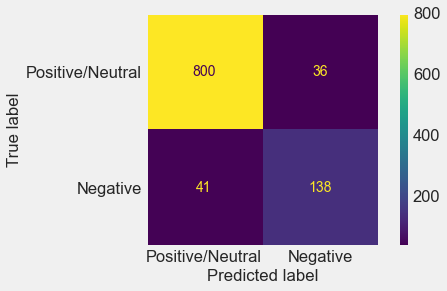

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       836
           1       0.79      0.77      0.78       179

    accuracy                           0.92      1015
   macro avg       0.87      0.86      0.87      1015
weighted avg       0.92      0.92      0.92      1015



In [140]:
fn.reporting(Baseline_LG,X_val,y_val)

This is a much improved scoring, the model was able to to tremendously gain recall, but did mistake some cases.

### Tuned Logistic Regression

In [141]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV

In [142]:
LG_param_space = {'clf__class_weight': [None,'balanced'],'clf__C':[.01,.1,1,5,10,100],
                                  'tfidf__ngram_range': [(1,1), (1,2),(1,3)],
                 'tfidf__max_df':[.90,1],'tfidf__use_idf': [True,False]}


In [143]:
%%time

LG_GS_Neg = GridSearchCV(estimator=Baseline_LG,param_grid=LG_param_space,cv=5,scoring=two_scorer,refit=True,error_score='raise')
                                
LG_GS_Neg.fit(X_train,y_train)

CPU times: user 23min 8s, sys: 5min 7s, total: 28min 16s
Wall time: 11min 59s


GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(ngram_range=(1, 2))),
                                       ('clf',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000))]),
             param_grid={'clf__C': [0.01, 0.1, 1, 5, 10, 100],
                         'clf__class_weight': [None, 'balanced'],
                         'tfidf__max_df': [0.9, 1],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tfidf__use_idf': [True, False]},
             scoring=make_scorer(fbeta_score, beta=2))

In [144]:
LG_GS_Neg.best_params_

{'clf__C': 10,
 'clf__class_weight': 'balanced',
 'tfidf__max_df': 0.9,
 'tfidf__ngram_range': (1, 1),
 'tfidf__use_idf': False}

In [145]:
cross_val_df.cross_val_report(LG_GS_Neg.best_estimator_,'Grid Logistic Additional Tweets',X_train,y_train)

[0.9293452823039031, 0.8099022928291222, 0.79372326005874]

In [146]:
validation_scores.report(LG_GS_Neg.best_estimator_,'Grid Logistic Addtiional Tweets',X_val,y_val)

[0.9221674876847291, 0.776536312849162, 0.7808988764044944]

In [147]:
X_val

1402    Startups: Free Premium Service on your  one st...
4801    Umm. Hello!! What about Android?! RT  Awesome ...
2356     Congrats on your iPhone app being featured at...
1484    like that is bad RT  Sitting at a bar listenin...
2427    UBER BRAND SMART: Going To move a ton of iPad ...
                              ...                        
9176        lol iPhone,weak. Get on that Lumia level bruh
1499    Hmm...cannot get Twitter searches to update in...
3291    Abba has gotten dissed at  two  #sxsw panels i...
9119    L.A. School District Officially Ends $ one . t...
2211    In #SXSW Ballroom D for  from  \none seat rese...
Name: processed_text, Length: 1015, dtype: object

In [91]:
LG_GS_Neg = pickle.load(open('../Saved_Models/final_logistic.sav', 'rb'))

In [149]:
tfidf = TfidfVectorizer(ngram_range=(1,1))

In [150]:
tfidf.fit_transform(X_val)

<1015x3010 sparse matrix of type '<class 'numpy.float64'>'
	with 15515 stored elements in Compressed Sparse Row format>

In [151]:
X_val

1402    Startups: Free Premium Service on your  one st...
4801    Umm. Hello!! What about Android?! RT  Awesome ...
2356     Congrats on your iPhone app being featured at...
1484    like that is bad RT  Sitting at a bar listenin...
2427    UBER BRAND SMART: Going To move a ton of iPad ...
                              ...                        
9176        lol iPhone,weak. Get on that Lumia level bruh
1499    Hmm...cannot get Twitter searches to update in...
3291    Abba has gotten dissed at  two  #sxsw panels i...
9119    L.A. School District Officially Ends $ one . t...
2211    In #SXSW Ballroom D for  from  \none seat rese...
Name: processed_text, Length: 1015, dtype: object

In [152]:
tfidf.fit_transform(X_val)

<1015x3010 sparse matrix of type '<class 'numpy.float64'>'
	with 15515 stored elements in Compressed Sparse Row format>

In [154]:
tfidf.vocabulary_

{'startups': 2462,
 'free': 989,
 'premium': 1982,
 'service': 2284,
 'on': 1791,
 'your': 2990,
 'one': 1792,
 'st': 2453,
 'job': 1365,
 'post': 1965,
 'if': 1254,
 'you': 2989,
 'answer': 106,
 'our': 1819,
 'two': 2763,
 'min': 1642,
 'survey': 2535,
 'sxsw': 2545,
 'sxswi': 2548,
 'startup': 2460,
 'launch': 1439,
 'umm': 2778,
 'hello': 1177,
 'what': 2896,
 'about': 8,
 'android': 95,
 'rt': 2196,
 'awesome': 198,
 'new': 1725,
 'version': 2830,
 'of': 1775,
 'for': 969,
 'iphone': 1338,
 'and': 93,
 'web': 2877,
 'site': 2343,
 'coming': 489,
 'after': 46,
 'congrats': 516,
 'app': 123,
 'being': 246,
 'featured': 906,
 'at': 164,
 'like': 1471,
 'that': 2632,
 'is': 1343,
 'bad': 205,
 'sitting': 2345,
 'bar': 219,
 'listening': 1486,
 'to': 2684,
 'music': 1697,
 'three': 2664,
 'people': 1881,
 'who': 2903,
 'all': 72,
 'nose': 1752,
 'down': 731,
 'waitress': 2856,
 'looks': 1520,
 'confused': 515,
 'uber': 2770,
 'brand': 306,
 'smart': 2364,
 'going': 1081,
 'move': 1680,

In [156]:
X_val

1402    Startups: Free Premium Service on your  one st...
4801    Umm. Hello!! What about Android?! RT  Awesome ...
2356     Congrats on your iPhone app being featured at...
1484    like that is bad RT  Sitting at a bar listenin...
2427    UBER BRAND SMART: Going To move a ton of iPad ...
                              ...                        
9176        lol iPhone,weak. Get on that Lumia level bruh
1499    Hmm...cannot get Twitter searches to update in...
3291    Abba has gotten dissed at  two  #sxsw panels i...
9119    L.A. School District Officially Ends $ one . t...
2211    In #SXSW Ballroom D for  from  \none seat rese...
Name: processed_text, Length: 1015, dtype: object

In [157]:
LG_GS_Neg.best_params_

{'clf__C': 10,
 'clf__class_weight': 'balanced',
 'tfidf__max_df': 0.9,
 'tfidf__ngram_range': (1, 1),
 'tfidf__use_idf': False}

In [158]:
y_val

1402    0
4801    0
2356    0
1484    0
2427    0
       ..
9176    1
1499    1
3291    0
9119    1
2211    0
Name: Sentiment, Length: 1015, dtype: uint8

In [159]:
corpus = X_val

In [160]:
vectorizer = TfidfVectorizer(ngram_range=(1,2),lowercase=True)

In [84]:
TfidfVectorizer.fit_transform(X_val)

TypeError: fit_transform() missing 1 required positional argument: 'raw_documents'

In [85]:
tokenizer = lambda docs: [vectorizer.build_tokenizer()(doc) for doc in docs]

tokenizer(corpus)

[['rt',
  'rt',
  'wonder',
  'street',
  'closure',
  'sxsw',
  'make',
  'google',
  'map',
  'show',
  'linkone',
  'panel',
  'moderator',
  'europe',
  'say',
  'spent',
  'three',
  'thousand',
  'roam',
  'charge',
  'iphone',
  'sxsw',
  'two',
  'thousand',
  'tenbet',
  'long',
  'ipad',
  'line',
  'go',
  'austinready',
  'iphone',
  'apps',
  'two',
  'make',
  'blogging',
  'easy',
  'linkreally',
  'google',
  'circle',
  'rt',
  'launch',
  'product',
  'plenty',
  'elsert',
  'pop',
  'store',
  'selling',
  'link',
  'viaapple',
  'open',
  'pop',
  'shop',
  'austin',
  'ipad',
  'two',
  'release',
  'linkfun',
  'watch',
  'rt',
  'apple',
  'open',
  'pop',
  'store',
  'austin',
  'sxsw',
  'linkgo',
  'apple',
  'pop',
  'shop',
  'congress',
  'avenue',
  'fridaygoogle',
  'hand',
  'free',
  'pi',
  'pi',
  'dayget',
  'ipad',
  'two',
  'give',
  'red',
  'cross',
  'japan',
  'first',
  'dayseventy',
  'mobile',
  'hit',
  'texas',
  'tribune',
  'come',
  '

In [86]:
vectorizer.fit_transform(X_val)

<1015x3010 sparse matrix of type '<class 'numpy.float64'>'
	with 15515 stored elements in Compressed Sparse Row format>

In [163]:
X_val

1402    Startups: Free Premium Service on your  one st...
4801    Umm. Hello!! What about Android?! RT  Awesome ...
2356     Congrats on your iPhone app being featured at...
1484    like that is bad RT  Sitting at a bar listenin...
2427    UBER BRAND SMART: Going To move a ton of iPad ...
                              ...                        
9176        lol iPhone,weak. Get on that Lumia level bruh
1499    Hmm...cannot get Twitter searches to update in...
3291    Abba has gotten dissed at  two  #sxsw panels i...
9119    L.A. School District Officially Ends $ one . t...
2211    In #SXSW Ballroom D for  from  \none seat rese...
Name: processed_text, Length: 1015, dtype: object

In [164]:
X_val

1402    Startups: Free Premium Service on your  one st...
4801    Umm. Hello!! What about Android?! RT  Awesome ...
2356     Congrats on your iPhone app being featured at...
1484    like that is bad RT  Sitting at a bar listenin...
2427    UBER BRAND SMART: Going To move a ton of iPad ...
                              ...                        
9176        lol iPhone,weak. Get on that Lumia level bruh
1499    Hmm...cannot get Twitter searches to update in...
3291    Abba has gotten dissed at  two  #sxsw panels i...
9119    L.A. School District Officially Ends $ one . t...
2211    In #SXSW Ballroom D for  from  \none seat rese...
Name: processed_text, Length: 1015, dtype: object

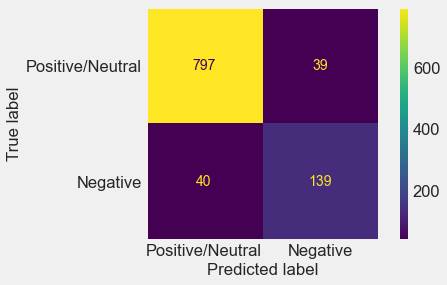

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       836
           1       0.78      0.78      0.78       179

    accuracy                           0.92      1015
   macro avg       0.87      0.86      0.87      1015
weighted avg       0.92      0.92      0.92      1015



In [165]:
fn.reporting(LG_GS_Neg.best_estimator_,X_val,y_val)

In [166]:
cross_val_df.history

,Name,mean_accuracy,std_accuracy,mean_precision,std_precision,mean_recall,std_recall,mean_f1,std_f1,notes
0,Baseline_svm,0.928094,0.001399,0.822222,0.093953,0.055855,0.023476,0.102999,0.042225,
1,SVM_BOW,0.928094,0.000916,0.796667,0.112744,0.060300,0.020735,0.110521,0.036022,"ngram 1,2"
2,SVM_TFIDF,0.928595,0.000853,0.806883,0.110288,0.066991,0.018701,0.122359,0.031673,"ngram_1,2"
3,Baseline Dummy,0.863880,0.009635,0.081676,0.036418,0.069139,0.026880,0.066957,0.012847,
4,SVM_TFIDF,0.928595,0.000853,0.790476,0.122706,0.071436,0.026914,0.128624,0.043989,"ngram_1,1"
5,Baseline Bayes,0.929264,0.002727,0.614499,0.087212,0.144994,0.028733,0.234251,0.043402,
6,Baseline Random Forrest,0.931104,0.002925,0.665598,0.120304,0.167291,0.037383,0.274529,0.049378,
7,Logistic_TFIDF,0.913545,0.009138,0.395436,0.086763,0.299001,0.072966,0.339969,0.078817,"N_grams2,2"
8,Logistic_TFIDF,0.898662,0.006983,0.357625,0.031299,0.437453,0.025999,0.393250,0.028001,"N_grams1,2"
9,Logistic_BOW,0.862876,0.006099,0.285229,0.022435,0.553308,0.062936,0.376122,0.032752,"N_Grams_1,2"


### Baseline Compliment Bayes

In [167]:
Comp_Bayes_Added_Neg = Pipeline(
    [
        ('tfidf',TfidfVectorizer(ngram_range=(1,2))),
        ('cnb', ComplementNB())
    ]
)

In [168]:
Comp_Bayes_Added_Neg.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('cnb', ComplementNB())])

In [169]:
cross_val_df.cross_val_report(Comp_Bayes_Added_Neg,'Comp Bayes Added Negs',X_train,y_train)

[0.8877394467601365, 0.3717404546672839, 0.9759869568300521]

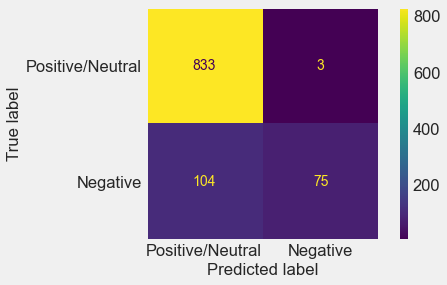

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       836
           1       0.96      0.42      0.58       179

    accuracy                           0.89      1015
   macro avg       0.93      0.71      0.76      1015
weighted avg       0.90      0.89      0.88      1015



In [170]:
fn.reporting(Comp_Bayes_Added_Neg,X_val,y_val)

### Tuned Bayes 

In [171]:
param_grid = {'cnb__alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
               'tfidf__ngram_range': [(1, 1), (1,2),(1,3)],'tfidf__use_idf':[True,False],
              'cnb__class_prior': [None, [.17, .83]],
                'cnb__fit_prior': [True, False]
                                      }

In [172]:
%%time

CB_GS_Added_Neg = GridSearchCV(estimator=Baseline_CB,param_grid=param_grid,cv=5,scoring=two_scorer,refit=True)
CB_GS_Added_Neg.fit(X_train,y_train)

CPU times: user 4min 31s, sys: 4.72 s, total: 4min 36s
Wall time: 4min 36s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf',
                                        TfidfVectorizer(ngram_range=(1, 2))),
                                       ('cnb', ComplementNB())]),
             param_grid={'cnb__alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
                         'cnb__class_prior': [None, [0.17, 0.83]],
                         'cnb__fit_prior': [True, False],
                         'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'tfidf__use_idf': [True, False]},
             scoring=make_scorer(fbeta_score, beta=2))

In [173]:
cross_val_df.cross_val_report(CB_GS_Added_Neg.best_estimator_,'Comp Bayes Added Negs',X_train,y_train)

[0.9080502463054186, 0.7973148802417095, 0.7143107999349358]

In [174]:
validation_scores.report(CB_GS_Added_Neg.best_estimator_,'Tuned Comp Bayes Added Neg',X_val,y_val)

[0.9152709359605912, 0.7988826815642458, 0.7409326424870466]

In [175]:
CB_GS_Added_Neg.best_params_

{'cnb__alpha': 0.1,
 'cnb__class_prior': None,
 'cnb__fit_prior': True,
 'tfidf__ngram_range': (1, 1),
 'tfidf__use_idf': False}

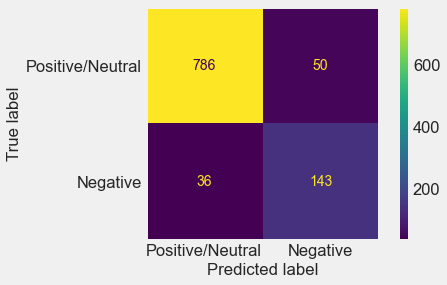

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       836
           1       0.74      0.80      0.77       179

    accuracy                           0.92      1015
   macro avg       0.85      0.87      0.86      1015
weighted avg       0.92      0.92      0.92      1015



In [176]:
fn.reporting(CB_GS_Added_Neg.best_estimator_,X_val,y_val)

In [177]:
validation_scores.history

,Name,accuracy,precision,recall,f1,notes
0,Baseline CB,0.926471,0.538462,0.125000,0.202899,
1,Logistic_TFIDF,0.901070,0.390244,0.571429,0.463768,"N_gram_1,2"
2,Tune Comp Bayes,0.840909,0.259542,0.607143,0.363636,
3,Logistic_TFIDF,0.871658,0.318182,0.625000,0.421687,"N_gram_1,1"
4,baseline_logistic,0.827540,0.248276,0.642857,0.358209,"n_grams 1,1,BoW"
5,Logistic_BOW,0.874332,0.327273,0.642857,0.433735,"N_gram_1,2"
6,Tuned Logistic,0.827540,0.248276,0.642857,0.358209,
7,Grid Search Random Forrest,0.655080,0.141844,0.714286,0.236686,
8,Grid Logistic Addtiional Tweets,0.922167,0.780899,0.776536,0.778711,
9,Tuned Comp Bayes Added Neg,0.915271,0.740933,0.798883,0.768817,


### Random Forrest

In [178]:
Baseline_RF_Add_Neg = Pipeline(
    [
        ('tfidf',TfidfVectorizer(ngram_range=(1,2))),
        ('RF', RandomForestClassifier())
    ]
)

In [179]:
Baseline_RF_Add_Neg.fit(X_train,y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('RF', RandomForestClassifier())])

In [180]:
cross_val_df.cross_val_report(Baseline_RF_Add_Neg,'Baseline Random Forrest_Add_Examples',X_train,y_train)

[0.947070253884047, 0.7225481835237934, 0.9626208426521625]

In [181]:
cross_val_df.history

,Name,mean_accuracy,std_accuracy,mean_precision,std_precision,mean_recall,std_recall,mean_f1,std_f1,notes
0,Baseline_svm,0.928094,0.001399,0.822222,0.093953,0.055855,0.023476,0.102999,0.042225,
1,SVM_BOW,0.928094,0.000916,0.796667,0.112744,0.060300,0.020735,0.110521,0.036022,"ngram 1,2"
2,SVM_TFIDF,0.928595,0.000853,0.806883,0.110288,0.066991,0.018701,0.122359,0.031673,"ngram_1,2"
3,Baseline Dummy,0.863880,0.009635,0.081676,0.036418,0.069139,0.026880,0.066957,0.012847,
4,SVM_TFIDF,0.928595,0.000853,0.790476,0.122706,0.071436,0.026914,0.128624,0.043989,"ngram_1,1"
5,Baseline Bayes,0.929264,0.002727,0.614499,0.087212,0.144994,0.028733,0.234251,0.043402,
6,Baseline Random Forrest,0.931104,0.002925,0.665598,0.120304,0.167291,0.037383,0.274529,0.049378,
7,Logistic_TFIDF,0.913545,0.009138,0.395436,0.086763,0.299001,0.072966,0.339969,0.078817,"N_grams2,2"
8,Comp Bayes Added Negs,0.887739,0.004822,0.975987,0.014207,0.371740,0.025968,0.537941,0.028075,
9,Logistic_TFIDF,0.898662,0.006983,0.357625,0.031299,0.437453,0.025999,0.393250,0.028001,"N_grams1,2"


In [182]:
X_train

3827    SXSW : Mistakes Made Building Netflix for iPho...
8496    Great visualisation of the ghost movement logi...
4606     No iPhone? No worries. Drop into one of our v...
3483     i heard the downtown location sold $ one m in...
3222    Google before you tweet" is the new "think bef...
                              ...                        
72      Gowalla's  promises to launch Foursquare check...
2820    As the geeks leave Austin and the music people...
7318    Clearly Apple has another daylight savings tim...
957     Apple to open pop up store at #SXSW in time fo...
1310    I sort of wish the pop-up Apple Store only sol...
Name: processed_text, Length: 8124, dtype: object

In [185]:
random_grid = {'RF__class_weight': ["balanced", "balanced_subsample"], 'tfidf__ngram_range': [(1, 1), (1,2),(1,3)],'tfidf__use_idf':[True,False],
                                    'RF__max_depth': [3,4,5,6,7,8,9,10, 15, 20, 30, None],'RF__min_samples_split': [2,4,6,8]}


In [195]:
%%time
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
halving_cv = HalvingGridSearchCV(Baseline_RF,param_grid=random_grid,scoring=two_scorer, n_jobs=-1, min_resources="exhaust", factor=3, cv=5)
halving_cv.fit(X_train,y_train)

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/

CPU times: user 33.9 s, sys: 3.92 s, total: 37.8 s
Wall time: 9min 1s


HalvingGridSearchCV(estimator=Pipeline(steps=[('tfidf',
                                               TfidfVectorizer(ngram_range=(1,
                                                                            2))),
                                              ('RF',
                                               RandomForestClassifier())]),
                    n_jobs=-1,
                    param_grid={'RF__class_weight': ['balanced',
                                                     'balanced_subsample'],
                                'RF__max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 15,
                                                  20, 30, None],
                                'RF__min_samples_split': [2, 4, 6, 8],
                                'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)],
                                'tfidf__use_idf': [True, False]},
                    scoring=make_scorer(fbeta_score, beta=2))

In [196]:
halving_cv.best_params_

{'RF__class_weight': 'balanced',
 'RF__max_depth': 20,
 'RF__min_samples_split': 8,
 'tfidf__ngram_range': (1, 1),
 'tfidf__use_idf': False}

In [ ]:
RF_GS_Added_Neg.best_params_

In [197]:
cross_val_df.cross_val_report(halving_cv.best_estimator_,'Random Forrest Added Negs Halving Search',X_train,y_train)

[0.9356219780219781, 0.7260276309056797, 0.9125037864906203]

In [ ]:
%%time
cross_val_df.cross_val_report(RF_GS_Added_Neg.best_estimator_,'Random Forrest Added Negs Grid Search',X_train,y_train)

In [198]:
validation_scores.report(halving_cv.best_estimator_,'Random Forrest Added Negs Halving Grid Search',X_val,y_val)

[0.9280788177339901, 0.6983240223463687, 0.8680555555555556]

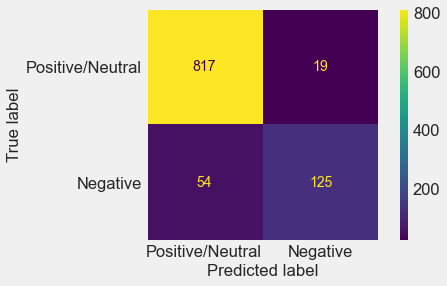

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       836
           1       0.87      0.70      0.77       179

    accuracy                           0.93      1015
   macro avg       0.90      0.84      0.87      1015
weighted avg       0.93      0.93      0.92      1015



In [199]:
fn.reporting(halving_cv.best_estimator_,X_val,y_val)

In [200]:
validation_scores.history

,Name,accuracy,precision,recall,f1,notes
0,Baseline CB,0.926471,0.538462,0.125000,0.202899,
1,Logistic_TFIDF,0.901070,0.390244,0.571429,0.463768,"N_gram_1,2"
2,Tune Comp Bayes,0.840909,0.259542,0.607143,0.363636,
3,Logistic_TFIDF,0.871658,0.318182,0.625000,0.421687,"N_gram_1,1"
4,baseline_logistic,0.827540,0.248276,0.642857,0.358209,"n_grams 1,1,BoW"
5,Logistic_BOW,0.874332,0.327273,0.642857,0.433735,"N_gram_1,2"
6,Tuned Logistic,0.827540,0.248276,0.642857,0.358209,
10,Random Forrest Added Negs Halving Grid Search,0.928079,0.868056,0.698324,0.773994,
7,Grid Search Random Forrest,0.655080,0.141844,0.714286,0.236686,
8,Grid Logistic Addtiional Tweets,0.922167,0.780899,0.776536,0.778711,


In [201]:
cross_val_df.history

,Name,mean_accuracy,std_accuracy,mean_precision,std_precision,mean_recall,std_recall,mean_f1,std_f1,notes
0,Baseline_svm,0.928094,0.001399,0.822222,0.093953,0.055855,0.023476,0.102999,0.042225,
1,SVM_BOW,0.928094,0.000916,0.796667,0.112744,0.060300,0.020735,0.110521,0.036022,"ngram 1,2"
2,SVM_TFIDF,0.928595,0.000853,0.806883,0.110288,0.066991,0.018701,0.122359,0.031673,"ngram_1,2"
3,Baseline Dummy,0.863880,0.009635,0.081676,0.036418,0.069139,0.026880,0.066957,0.012847,
4,SVM_TFIDF,0.928595,0.000853,0.790476,0.122706,0.071436,0.026914,0.128624,0.043989,"ngram_1,1"
5,Baseline Bayes,0.929264,0.002727,0.614499,0.087212,0.144994,0.028733,0.234251,0.043402,
6,Baseline Random Forrest,0.931104,0.002925,0.665598,0.120304,0.167291,0.037383,0.274529,0.049378,
7,Logistic_TFIDF,0.913545,0.009138,0.395436,0.086763,0.299001,0.072966,0.339969,0.078817,"N_grams2,2"
8,Comp Bayes Added Negs,0.887739,0.004822,0.975987,0.014207,0.371740,0.025968,0.537941,0.028075,
9,Logistic_TFIDF,0.898662,0.006983,0.357625,0.031299,0.437453,0.025999,0.393250,0.028001,"N_grams1,2"


The best model appears to be logistic regression with the grid search parameters, that may be the best model for trying on the test data. I will also try to make a model with a neural network.

In [203]:
cross_val_df.history.to_csv('cross_val_scores')
validation_scores.history.to_csv('val_scores')

In [61]:
filename = 'final_logistic.sav'
pickle.dump(LG_GS_Neg, open(filename, 'wb'))

NameError: name 'LG_GS_Neg' is not defined

In [80]:
LG_GS_Neg = pickle.load(open('final_logistic.sav', 'rb'))

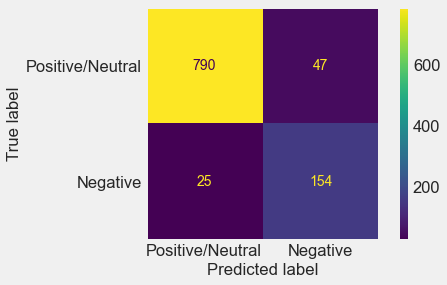

              precision    recall  f1-score   support

           0       0.97      0.94      0.96       837
           1       0.77      0.86      0.81       179

    accuracy                           0.93      1016
   macro avg       0.87      0.90      0.88      1016
weighted avg       0.93      0.93      0.93      1016



In [83]:
fn.reporting(LG_GS_Neg.best_estimator_,X_test,y_test)